In [1]:
import numpy as np 
import pandas as pd
import torch 

import sys
import os

current_path = notebook_dir = os.getcwd()
working_dir = os.path.abspath(os.path.join(current_path, '..','..'))
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

## Load Time Series:

In [2]:
np.random.seed(42)
t = np.linspace(0, 2*np.pi, 100)  # 50 points
x = np.sin(t)         
y = np.sin(t + np.pi/3) + 0.1 * np.random.randn(len(t)) # décalage en phase + bruit 
z = np.cos(t) + 0.1 * np.random.randn(len(t))  # autre série + bruit 

## Information, Entropy and Transfer Entropy:
- Calcul du 'Transfer Entropy' directement par discrétisation. (Ce n'est pas forcément adapté pour des signaux continues). 
- Notion de fenêtre glissante (arg `window_size`) qui calculent les mesures localement (sur une fenêtre glissante de taille window_size) 
-

In [3]:

from jupyter_ipynb.Entropy_and_information.entropy import TimeSeriesInfo
# Instanciation de la classe
tsi = TimeSeriesInfo(nb_bins=10)

# Exemple 1 : I(X;Y) sur des fenêtres glissantes
mi_values = tsi.sliding_window_mutual_info(x, y, window_size=6)
print("Mutual Information (X->Y) sur fenêtres glissantes:", mi_values)

# Exemple 2 : Transfer Entropy (X->Y) ~ I(X_t; Y_{t+1} | Y_t)
te_values = tsi.sliding_window_transfer_entropy(x, y, window_size=6)
print("Transfer Entropy (X->Y) sur fenêtres glissantes:", te_values)

# Exemple 3 : Transfer Entropy multi-séries {X, Z} -> Y
multi_te_values = tsi.sliding_window_multi_transfer_entropy([x, z], y, window_size=6)
print("Multi Transfer Entropy ({X, Z} -> Y) sur fenêtres glissantes:", multi_te_values)

Mutual Information (X->Y) sur fenêtres glissantes: [1.7917594692280547, 1.5607104090414061, 1.5607104090414061, 1.2424533248939997, 1.2424533248939997, 1.2424533248939997, 1.2424533248939997, 1.5607104090414061, 1.2424533248939997, 1.329661348854758, 1.329661348854758, 1.2424533248939997, 1.2424533248939997, 1.5607104090414061, 1.5607104090414061, 1.5607104090414061, 1.5607104090414061, 1.329661348854758, 1.5607104090414061, 1.3296613488547582, 1.329661348854758, 1.329661348854758, 1.5607104090414063, 1.5607104090414063, 1.242453324894, 1.5607104090414061, 1.329661348854758, 1.7917594692280547, 1.7917594692280547, 1.7917594692280547, 1.7917594692280547, 1.7917594692280547, 1.5607104090414061, 1.5607104090414061, 1.5607104090414061, 1.329661348854758, 1.0114042647073516, 1.329661348854758, 1.5607104090414061, 1.5607104090414061, 1.5607104090414061, 1.2424533248939997, 1.5607104090414061, 1.2424533248939997, 1.2424533248939997, 1.5607104090414061, 1.5607104090414061, 1.5607104090414061, 

In [4]:
from jupyter_ipynb.Entropy_and_information.lagged_feature import KSGEstimator,KDEEstimator,TimeSeriesTECalculator

data_dict = {
    'x': x,
    'y': y,
    'z': z
}

# 2) Choix des lags : ex. X(t), X(t-1), Z(t), Y(t) en condition => on veut TE(X,Z -> Y(t+1) | Y(t))
#    => On inclut y(t) dans la condition => lags_dict['y'] = [0]
#    => On inclut x(t) et x(t-1) => lags_dict['x'] = [0,1]
#    => On inclut z(t) => lags_dict['z'] = [0]
lags_dict = {
    'x': [0, 1],
    'z': [0],
    'y': [0]  # Y(t) en condition
}

# 3) Instancier un estimateur KSG => version non-simplifiée
ksg_est = KSGEstimator(k=5, simplified=False)

# 4) Créer le calculateur TE
te_calc = TimeSeriesTECalculator(estimator=ksg_est)

# 5) Calculer TE dans des fenêtres glissantes
#    TE({X(t),X(t-1),Z(t)} -> Y(t+1) | Y(t))
#    window_size=10
te_values_ksg = te_calc.sliding_window_te(
    data_dict=data_dict,
    lags_dict=lags_dict,
    target_var='y',
    target_offset=1,    # Y(t+1)
    window_size=10
)
print("KSG1 TE({X,Z}->Y):", te_values_ksg)

# 6) Idem version simplifiée KSG
ksg_est_simpl = KSGEstimator(k=5, simplified=True)
te_calc_simpl = TimeSeriesTECalculator(estimator=ksg_est_simpl)
te_values_simpl = te_calc_simpl.sliding_window_te(
    data_dict=data_dict,
    lags_dict=lags_dict,
    target_var='y',
    target_offset=1,
    window_size=10
)
print("KSG simplifié TE({X,Z}->Y):", te_values_simpl)

# 7) KDE
kde_est = KDEEstimator(bandwidth=0.3)
te_calc_kde = TimeSeriesTECalculator(estimator=kde_est)
te_values_kde = te_calc_kde.sliding_window_te(
    data_dict=data_dict,
    lags_dict=lags_dict,
    target_var='y',
    target_offset=1,
    window_size=10
)
print("KDE TE({X,Z}->Y):", te_values_kde)

KSG1 TE({X,Z}->Y): [-0.4940915761200504, -0.6186732984758714, -0.27144872866025116, -0.2741176450956444, -0.37592975182260124, -0.45435919491586185, -0.277963657950552, -0.557887808090221, -0.6552760857105757, -0.4218223131001504, -0.564660958905578, -0.6165406658476011, -0.6488518995815058, -0.5515018299956838, -0.424696910232514, -0.5753341405147507, -0.5485338437294496, -0.4153680040776824, -0.6886693365429735, -0.6327128849109209, -0.7213444653685763, -0.49210279208899843, -0.5248217901142953, -0.45413604969884513, -0.6684524514810706, -0.8309376448847872, -0.8272429362899694, -0.9047564440682758, -0.9053903921106845, -0.663879508922697, -0.631805009636967, -0.6094198931755757, -0.5445509389967407, -0.3291448228511038, -0.4779762095123312, -0.5490709180507476, -0.5225607810101323, -0.4593559020423925, -0.6294497861146024, -0.5177325606352223, -0.5467002914829426, -0.5435564056056661, -0.6157119296393314, -0.5430026002280874, -0.4061602615658946, -0.4807539397906839, -0.601769573953

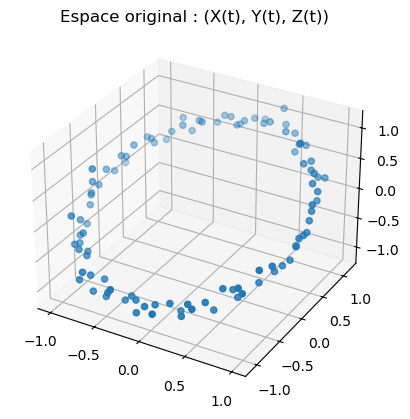

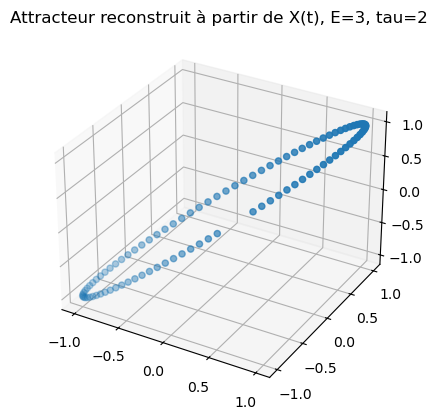

Corrélation CCM (X -> Y) = 1.000
CCM suggère que X a une influence positive sur Y (corrélation > 0).
Corrélation CCM (Y -> X) = 1.000
CCM suggère que Y a une influence positive sur X.


In [5]:
from jupyter_ipynb.Entropy_and_information.CCM import ccm_reconstruct,correlation_coefficient
import matplotlib.pyplot as plt
# ---------------------------
# 2) Graphique 3D (X,Y,Z) original
# ---------------------------
# Plot de l'espace "réel" (x(t), y(t), z(t)) 
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')
ax1.scatter(x, y, z)
ax1.set_title("Espace original : (X(t), Y(t), Z(t))")
plt.show()

# ---------------------------
# 3) Reconstruction d'attracteur en 3D à partir de X(t)
# ---------------------------
# Prenons E=3, tau=2 pour l'illustration
E = 3
tau = 2
N = len(x)
start_index = (E - 1)*tau
embedding = []
for i in range(start_index, N):
    coords = [x[i - e*tau] for e in range(E)]
    embedding.append(coords)
embedding = np.array(embedding)  # shape (N - start_index, 3)

# Plot 3D de l'attracteur reconstruit
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax2.set_title("Attracteur reconstruit à partir de X(t), E=3, tau=2")
plt.show()

# ---------------------------
# 4) Convergent Cross Mapping: X -> Y
# ---------------------------
# Paramètres de CCM
ccm_dim = 3
ccm_tau = 1
ccm_k = 4

# On obtient y_true, y_est
y_true, y_est = ccm_reconstruct(
    cause_series=x,
    effect_series=y,
    E=ccm_dim,
    tau=ccm_tau,
    k=ccm_k
)

# Corrélation
rho = correlation_coefficient(y_true, y_est)
print(f"Corrélation CCM (X -> Y) = {rho:.3f}")

# Interprétation du signe
if rho > 0.1:  # Seuil arbitraire
    print("CCM suggère que X a une influence positive sur Y (corrélation > 0).")
else:
    print("Aucune influence notable détectée de X vers Y (corrélation faible ou nulle).")

# ---------------------------
# 5) Convergent Cross Mapping: Y -> X (test inverse)
# ---------------------------
x_true, x_est = ccm_reconstruct(
    cause_series=y,
    effect_series=x,
    E=ccm_dim,
    tau=ccm_tau,
    k=ccm_k
)
rho_yx = correlation_coefficient(x_true, x_est)
print(f"Corrélation CCM (Y -> X) = {rho_yx:.3f}")
if rho_yx > 0.1:
    print("CCM suggère que Y a une influence positive sur X.")
else:
    print("Aucune influence notable détectée de Y vers X.")

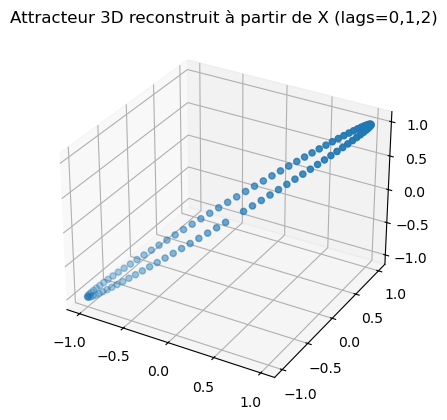

[X-only attracteur] Corrélation CCM(X->Y) = 1.000


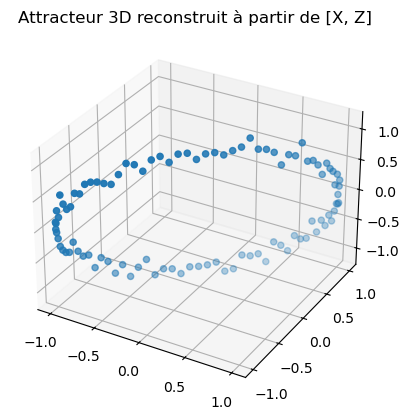

[X+Z attracteur] Corrélation CCM(X,Z->Y) = 1.000


In [6]:
from jupyter_ipynb.Entropy_and_information.Multivariate_CCM import build_multivariate_embedding,ccm_reconstruct_multivariate
# 2) Premier cas : Attracteur à partir de X seul
#    => disons qu'on veut X(t), X(t-1), X(t-2)
#    => on va tester si X reconstruit Y
data_dict = {'x': x, 'y': y, 'z': z}

lags_for_x_only = {
    'x': [0, 1, 2],  # 3 composantes => embedding dimension=3
    'y': [],         # pas de lags pour y => on ne l'utilise pas dans l'attracteur
    'z': []          # pas de lags pour z
}

emb_x, valid_t_x = build_multivariate_embedding(data_dict, lags_for_x_only)
# On va visualiser ce nuage 3D (embedding) => correspond à (X(t), X(t-1), X(t-2))
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')
ax1.scatter(emb_x[:, 0], emb_x[:, 1], emb_x[:, 2])
ax1.set_title("Attracteur 3D reconstruit à partir de X (lags=0,1,2)")
plt.show()

# CCM : X -> Y
y_true, y_est = ccm_reconstruct_multivariate(embedding=emb_x,
                                                valid_time=valid_t_x,
                                                effect_series=y,
                                                k=4,
                                                use_weighted_mean=True)
rho_x_y = correlation_coefficient(y_true, y_est)
print(f"[X-only attracteur] Corrélation CCM(X->Y) = {rho_x_y:.3f}")

# 3) Second cas : Attracteur multivarié à partir de [X, Z]
#    => X(t), X(t-1), Z(t) => dimension=3
#    => on teste la reconstruction de Y
lags_for_xz = {
    'x': [0, 1],
    'z': [0],
    'y': []  # on n'utilise pas y dans l'attracteur
}

emb_xz, valid_t_xz = build_multivariate_embedding(data_dict, lags_for_xz)

# Visualisation 3D => (X(t), X(t-1), Z(t))
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')
ax2.scatter(emb_xz[:, 0], emb_xz[:, 1], emb_xz[:, 2])
ax2.set_title("Attracteur 3D reconstruit à partir de [X, Z]")
plt.show()

# CCM : [X, Z] -> Y
y_true_xz, y_est_xz = ccm_reconstruct_multivariate(embedding=emb_xz,
                                                    valid_time=valid_t_xz,
                                                    effect_series=y,
                                                    k=4,
                                                    use_weighted_mean=True)
rho_xz_y = correlation_coefficient(y_true_xz, y_est_xz)
print(f"[X+Z attracteur] Corrélation CCM(X,Z->Y) = {rho_xz_y:.3f}")

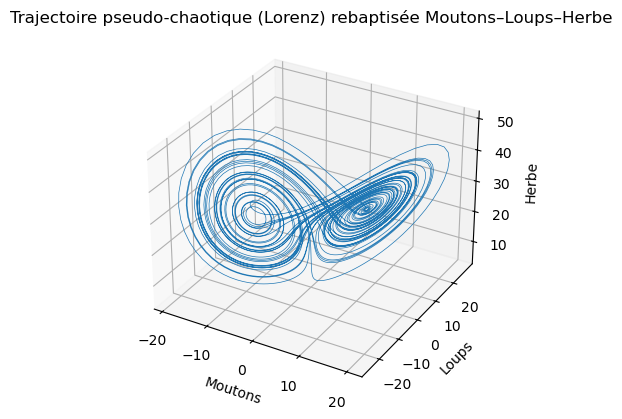

Corrélation CCM(Loups->Moutons) = 1.000
Corrélation CCM(Moutons->Loups) = 1.000


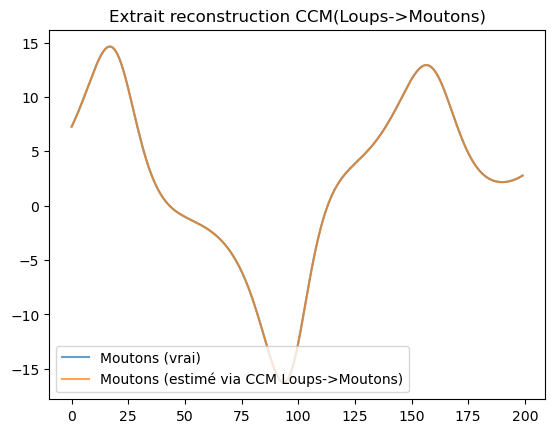

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple

#####################
# 1) Système type Lorenz
#####################
def lorenz_system(state, sigma=10.0, rho=28.0, beta=8/3):
    """
    Équation de Lorenz :
    dx/dt = sigma*(y - x)
    dy/dt = x*(rho - z) - y
    dz/dt = x*y - beta*z
    """
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

def simulate_lorenz(initial_state: np.ndarray,
                    dt: float = 0.01,
                    steps: int = 10000) -> np.ndarray:
    """
    Intégration d'Euler simple pour le système de Lorenz.
    Retourne un tableau (steps, 3) avec la trajectoire [x(t), y(t), z(t)].
    """
    traj = np.zeros((steps, 3))
    traj[0] = initial_state
    for i in range(1, steps):
        deriv = lorenz_system(traj[i-1])
        traj[i] = traj[i-1] + dt * deriv
    return traj

#####################
# 2) Génération des données "Moutons, Loups, Herbe"
#####################
np.random.seed(42)
initial_state = np.array([5.0, 5.0, 5.0])  # point de départ
data_lorenz = simulate_lorenz(initial_state, dt=0.01, steps=6000)
# Tronquons un peu le début pour éviter les transitoires
data_lorenz = data_lorenz[1000:]  # shape (5000, 3)

# On renomme : Moutons = X, Loups = Y, Herbe = Z
Moutons = data_lorenz[:, 0]
Loups = data_lorenz[:, 1]
Herbe = data_lorenz[:, 2]

#####################
# 3) Affichage 3D : "Papillon"
#####################
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(Moutons, Loups, Herbe, lw=0.5)
ax.set_xlabel("Moutons")
ax.set_ylabel("Loups")
ax.set_zlabel("Herbe")
ax.set_title("Trajectoire pseudo-chaotique (Lorenz) rebaptisée Moutons–Loups–Herbe")
plt.show()

#####################
# 4) Petit test CCM
#####################

# (a) On échantillonne la fin de la trajectoire (par ex. 1000 points) pour avoir la série
M = 1000
Moutons_sample = Moutons[-M:]
Loups_sample = Loups[-M:]
Herbe_sample = Herbe[-M:]

# (b) On applique CCM => vous pouvez réutiliser votre fonction ccm_reconstruct_multivariate
#     ou ccm_reconstruct mono-série. Ex. : Loups -> Moutons
#     On donne juste un squelette illustratif (simplifié) :

from sklearn.neighbors import NearestNeighbors

def ccm_reconstruct(cause_series: np.ndarray,
                    effect_series: np.ndarray,
                    E: int = 3,
                    tau: int = 1,
                    k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    """
    CCM simple, monovarié. Reconstruit effect_series à partir de l'attracteur de cause_series.
    """
    N = len(cause_series)
    start_index = (E - 1) * tau
    # Attracteur
    M_points = []
    valid_t = []
    for t in range(start_index, N):
        coords = [cause_series[t - i*tau] for i in range(E)]
        M_points.append(coords)
        valid_t.append(t)
    M_points = np.array(M_points)
    valid_t = np.array(valid_t)

    # k-NN
    nbrs = NearestNeighbors(n_neighbors=k).fit(M_points)
    y_pred = []
    y_true = []
    for i, mp in enumerate(M_points):
        dist, idxs = nbrs.kneighbors(mp.reshape(1, -1))
        # Weighted average
        d = dist[0]
        d = np.where(d<1e-12, 1e-12, d)
        w = 1/d
        w /= w.sum()
        neighbors_t = valid_t[idxs[0]]
        val_neighbors = effect_series[neighbors_t]
        val_est = np.sum(val_neighbors * w)
        y_pred.append(val_est)
        # Valeur réelle
        t_i = valid_t[i]
        y_true.append(effect_series[t_i])
    return np.array(y_true), np.array(y_pred)

def corr(x, y):
    return np.corrcoef(x, y)[0, 1]

# Test : CCM(Loups->Moutons)
E_dim = 3
tau_lag = 2
k_nn = 6
y_true, y_est = ccm_reconstruct(Loups_sample, Moutons_sample,
                                E=E_dim, tau=tau_lag, k=k_nn)
r_loups_moutons = corr(y_true, y_est)
print(f"Corrélation CCM(Loups->Moutons) = {r_loups_moutons:.3f}")

# Test : CCM(Moutons->Loups)
y_true2, y_est2 = ccm_reconstruct(Moutons_sample, Loups_sample,
                                  E=E_dim, tau=tau_lag, k=k_nn)
r_moutons_loups = corr(y_true2, y_est2)
print(f"Corrélation CCM(Moutons->Loups) = {r_moutons_loups:.3f}")

# Idem si vous voulez tester Herbe -> Moutons, etc.

plt.figure()
plt.plot(y_true[:200], label="Moutons (vrai)", alpha=0.7)
plt.plot(y_est[:200], label="Moutons (estimé via CCM Loups->Moutons)", alpha=0.7)
plt.title("Extrait reconstruction CCM(Loups->Moutons)")
plt.legend()
plt.show()